# Gradient Symbolic Computation

see `TPR_example.ipynb` for details about the TP representation and one possible empirical phenomenon, that can be handled with GSC.

In [1]:
# Imports
from src.classes.Grammar import Grammar
from src.gsc.gsc_network import Net
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
# Set seed for reproducibility
torch.manual_seed(123)

## Grammar and Harmonic Constraints

In [2]:
# Fillers and Roles
fillers = ["bh", "b", "u", "d", "dh"]
# The simplest possible roles: s1 = first position in the word, s2 = second position ....
roles = ["s1", "s2", "s3","s4"]

"""similarities = torch.tensor([[1, 0.5, 0, 0, 0,0],
                             [0.5, 1, 0, 0, 0,0],
                             [0, 0, 1, 0, 0,0],
                             [0, 0, 0, 1, 0.5,0],
                             [0, 0, 0, 0.5, 1,0],
                              [0, 0, 0, 0, 0,1]])"""

# Build Grammar
G = Grammar(fillers, roles, emtpyFiller="#")
#G = Grammar(fillers, roles, emtpyFiller="#", fillerSimilarities=similarities)

Buil Filler Matrix
Representations built after 224 attempts

Build role Matrix
Representations built after 219 attempts



In [3]:
print(f"Roles representation matrix:\n{pd.DataFrame(G.bind.R.numpy(), index=roles, columns=roles)}\n")
print(f"Fillers representation matrix:\n{pd.DataFrame(G.bind.F.numpy(), index=fillers, columns=fillers)}\n")

Roles representation matrix:
          s1        s2        s3        s4
s1 -0.706786 -0.245139 -0.450434  0.487308
s2  0.334344 -0.780347 -0.430909 -0.305926
s3  0.537700 -0.161073  0.128452  0.817578
s4 -0.315509 -0.552287  0.771314 -0.022488

Fillers representation matrix:
          bh         b         u         d        dh         #
bh  0.268915 -0.226856  0.369631 -0.588528  0.522140  0.347274
b  -0.040153 -0.228537  0.764934  0.441927  0.133732 -0.384513
u  -0.684379  0.453295  0.208536 -0.449616  0.076696 -0.273175
d  -0.021590 -0.388657  0.257805 -0.388855 -0.793899  0.023089
dh  0.676026  0.534180  0.126280 -0.201687 -0.152363 -0.421664
#   0.014784 -0.504409 -0.390321 -0.253565  0.223861 -0.691804



## Single Constituents Harmony

The following code sets the harmony values for single bindings. 
For instance the constraint `("b/s1", 2)` means that the segment "b" in first position ("s1") improves the general harmony by 2. 

There will be *Harmony crosstalk* if the vector representing those bindings are not independent (dot product == 0). Let's suppose that the vector representing "b/s1" has a non-null dotproduct with the vector representing "bh/s1". Then "bh/s1" will also improve its harmony by a factor $H_{b/s1} \times (b/s1 \cdot bh/s1)$


In [4]:
# Single Harmony constraints
cons = [("b/s1", 5), ("u/s2", 5), ("dh/s3", 2), ("#/s4", 2), ("d/s3",2)] # initialize preferences (dummy-way to reinforce the desired output)
G.update_Hc(cons)

In [5]:
harmonies = G.Hc.numpy()
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3,s4
bh,0.0,0.0,0.0,0.0
b,5.0,0.0,0.0,0.0
u,0.0,5.0,0.0,0.0
d,0.0,0.0,2.0,0.0
dh,0.0,0.0,2.0,0.0
#,0.0,0.0,0.0,2.0


<AxesSubplot:>

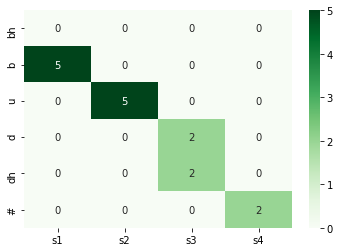

In [6]:
sns.heatmap(harmonies, annot=True, cmap="Greens")

## Pairwise Harmonies:

These constraints provide a way to declare Harmonic Constraints in the GSC. 
Ex.:

`("u/s2" "d/s3", -3)` means that the co-occurence of "u" in the secondo position and "d" in the third position updates the total Harmony by -3 points. This  (indirectly) implement the preference for "dh" in "s3".


In [7]:
# Pairwise Harmony
# Matrix dim: (nF, nR, nF, nR)
cons = [("b/s1", "d/s3", -2), # having both "b" abd "d" unaspirated decreases harmony
        ("bh/s1", "dh/s3", -10), # having both "b" and "d" aspirated is blocked
        ("b/s1", "dh/s3", 20)] # Prefer alternation
G.update_Hcc(cons)

In [8]:
# Harmonies for the binding : b/s1
harmonies = G.Hcc.numpy()[:,:,1,0]
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3,s4
bh,0.0,0.0,0.0,0.0
b,0.0,0.0,0.0,0.0
u,0.0,0.0,0.0,0.0
d,0.0,0.0,-2.0,0.0
dh,0.0,0.0,20.0,0.0
#,0.0,0.0,0.0,0.0


<AxesSubplot:>

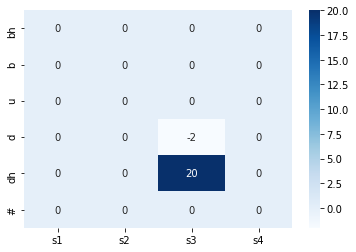

In [9]:
sns.heatmap(harmonies, annot=True, cmap="Blues")

This matrix represents the occurence of "b" in the first position and tells us, that if this is the case, then a plain, unaspirated, "d" in the third position is dispreferred and "dh" should be preferred. 

## GSC Net

In [10]:
# Custom settings (these substitute the hard-coded settings)

# ---------------------------------------
#           GSC NET
# ---------------------------------------

custom_settings = {"epochs": 5,
                   "tgtStd": 0.00125,
                   "emaFactor": 0.01,
                   "emaSpeedTol": 0.002,
                   "dt": 1e-10,
                   "TDecayRate": 0.05,
                   "TInit" : 1e-5,
                   "lambdaDecayRate": 0.7,
                   "lambdaMin": 0.01,
                   "maxSteps": 3000,
                   "printInterval": 1000,
                   'bowl_center': 0.4,
                   'beta_min_offset': .01}
# Initialize
N = Net(G, custom_settings=custom_settings, extData_path="data/inp_pandas.csv")


Input processed: b-bh-u-dh-u

Input processed: b-u-dh-#

Input processed: b-bh-u-dh-d

Value for Q set to 47.397059233392774
LAMBDA RECOMMENDED: 0.0035673874457757674, ACTUAL LAMBDA = 0.011387


If you want to change to the recommended Lambda value press 'y', else any other key: y


T RECOMMENDED: 3.900753695636446e-05, ACTUAL T = 1e-05


If you want to change to the recommended value press 'y', else any other key: y


The external data were provided in form of a simple csv file and were imported in the GSCNet using `pandas`:

In [11]:
# EXTERNAL INPUTS 

# Read dataframe
inputs = pd.read_csv("data/inp_pandas.csv", sep=",")

inputNames = []
nStimuli = len(inputs['id'].unique())

# Initialize stimuli tensor
stimuli = torch.zeros((nStimuli, len(fillers) + 1, len(roles)))

# Loop over the single inputs as whole
for idx, i in enumerate(inputs['id'].unique()):
    inp_string = ""
    stimulus = inputs[inputs.id == i].to_numpy()[:, 1:]

    # Loop over the fillers in a given input
    for filler in stimulus:
        fidx = N.filler2index[filler[0]]
        inp_string += filler[0] + "-"
        for roledix in range(N.grammar.bind.nR):
            stimuli[idx, fidx, roledix] = filler[roledix+1]
    print(f"Input processed: {inp_string[:-1]}\n")
    # Store the names for later plotting
    inputNames.append(inp_string[:-1])

Input processed: b-bh-u-dh-u

Input processed: b-u-dh-#

Input processed: b-bh-u-dh-d



+ First inp: gradient blend for the root *{b, bh}udhu*:
+ Second inp: discrete *budh*
+ Third inp: gradient blend in both first and final position *{b,bh}u{d,dh}*

<small>'#' stands for an empty position</small>

     s1   s2   s3   s4
bh  0.8  0.0  0.0  0.0
b   0.7  0.0  0.0  0.0
u   0.0  1.0  0.0  1.0
d   0.0  0.0  0.0  0.0
dh  0.0  0.0  1.0  0.0
#   0.0  0.0  0.0  0.0


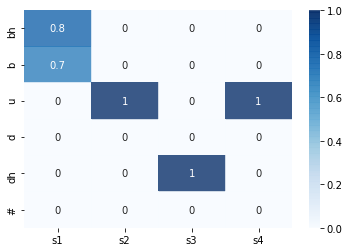

Representation of '(b,bh)udh'


In [12]:
b_bh_ud = N.stimuli[0,:,:].numpy()
b_bh_ud = pd.DataFrame(b_bh_ud, columns=roles, index=fillers)
print(b_bh_ud)
sns.heatmap(b_bh_ud, alpha=.8, cmap="Blues", annot=True)
plt.show()
print("Representation of '(b,bh)udh'")

## Training (Optimization + Quantization)

In [13]:
# Run
p = N()

Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035673874457757674	 Harmony: 77.29187774658203

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.257407  0.40000  0.400000  0.400000
b   0.822008  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.421098
d   0.400000  0.40000  0.407511  0.400000
dh  0.400000  0.40000  0.755847  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9380918197139534

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.003567388219470052	 Harmony: 49.64276885986328

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.800000  0.399452  0.400897  0.399566
b   0.700000  0.399675  0.400461  0.399705
u   0.399041  1.000000  0.401157  1.000


Stimulus routine::  33%|███▎      | 1/3 [00:05<00:10,  5.37s/it]


Last best Harmony: 49.64109818649841

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035673897684072456	 Harmony: 77.3315658569336

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.238835  0.40000  0.400000  0.400000
b   0.831741  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.407100  0.400000
dh  0.400000  0.40000  0.763872  0.400000
#   0.400000  0.40000  0.400000  0.463295
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.9232806245635377

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.003567390542101374	 Harmony: 57.13508605957031

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.238676  0.399780  0.400410  0.399851
b   1.000000  0.399556  0.400639  0.399591
u   


Stimulus routine::  67%|██████▋   | 2/3 [00:10<00:05,  5.14s/it]


Last best Harmony: 57.1319877358722

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035673920910381397	 Harmony: 76.85030364990234

epoch : 1
stimNum : 3

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.256199  0.40000  0.400000  0.400000
b   0.826274  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.413660  0.400000
dh  0.400000  0.40000  0.751572  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9349186798565874

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035673928647318347	 Harmony: 72.24555969238281

epoch : 1
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.700000  0.399493  0.400692  0.399791
b   1.000000  0.399554  0.400636  0.399654



Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 72.24437604224349

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.003567394413668161	 Harmony: 77.8535385131836

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.257407  0.40000  0.400000  0.400000
b   0.822008  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.421098
d   0.400000  0.40000  0.407511  0.400000
dh  0.400000  0.40000  0.755847  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9380918197139534

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035673951873617113	 Harmony: 49.64276885986328

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.800000  0.399453  0.400895  0.399565
b   0.700000  0.399676  0.400461  0.399705
u


Stimulus routine::  33%|███▎      | 1/3 [00:05<00:10,  5.25s/it]


Last best Harmony: 49.641102834489544

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035673967362971704	 Harmony: 77.42059326171875

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.238835  0.40000  0.400000  0.400000
b   0.831741  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.407100  0.400000
dh  0.400000  0.40000  0.763872  0.400000
#   0.400000  0.40000  0.400000  0.463295
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.9232806245635377

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.003567397509990432	 Harmony: 57.13507843017578

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.238675  0.399780  0.400411  0.399850
b   1.000000  0.399556  0.400638  0.399590
u 


Stimulus routine::  67%|██████▋   | 2/3 [00:10<00:05,  5.31s/it]


Last best Harmony: 57.131977113715465

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035673990589255955	 Harmony: 77.22393035888672

epoch : 2
stimNum : 3

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.256199  0.40000  0.400000  0.400000
b   0.826274  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.413660  0.400000
dh  0.400000  0.40000  0.751572  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9349186798565874

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.003567399832618424	 Harmony: 72.24555969238281

epoch : 2
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.700000  0.399494  0.400692  0.399791
b   1.000000  0.399553  0.400636  0.399654


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 72.24437325856307

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035674013815530157	 Harmony: 77.33259582519531

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.257407  0.40000  0.400000  0.400000
b   0.822008  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.421098
d   0.400000  0.40000  0.407511  0.400000
dh  0.400000  0.40000  0.755847  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9380918197139534

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035674021552458317	 Harmony: 49.64276885986328

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.800000  0.399452  0.400896  0.399566
b   0.700000  0.399675  0.400461  0.399705


Stimulus routine::  33%|███▎      | 1/3 [00:05<00:10,  5.16s/it]


Last best Harmony: 49.64109950494142

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.003567403704179556	 Harmony: 77.82162475585938

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.238835  0.40000  0.400000  0.400000
b   0.831741  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.407100  0.400000
dh  0.400000  0.40000  0.763872  0.400000
#   0.400000  0.40000  0.400000  0.463295
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.9232806245635377

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035674044778719514	 Harmony: 57.13507843017578

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.238675  0.399782  0.400411  0.399851
b   1.000000  0.399555  0.400639  0.399590
u  


Stimulus routine::  67%|██████▋   | 2/3 [00:10<00:05,  5.05s/it]


Last best Harmony: 57.131971645167994

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.003567406026805512	 Harmony: 77.3780517578125

epoch : 3
stimNum : 3

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.256199  0.40000  0.400000  0.400000
b   0.826274  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.413660  0.400000
dh  0.400000  0.40000  0.751572  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9349186798565874

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035674068004974743	 Harmony: 72.24555969238281

epoch : 3
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.700000  0.399494  0.400693  0.399790
b   1.000000  0.399553  0.400636  0.399654



Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 72.24437737626481

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035674083494303312	 Harmony: 77.19644165039062

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.257407  0.40000  0.400000  0.400000
b   0.822008  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.421098
d   0.400000  0.40000  0.407511  0.400000
dh  0.400000  0.40000  0.755847  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9380918197139534

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035674091231222933	 Harmony: 49.64276885986328

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.800000  0.399452  0.400896  0.399564
b   0.700000  0.399675  0.400463  0.399705


Stimulus routine::  33%|███▎      | 1/3 [00:05<00:10,  5.46s/it]


Last best Harmony: 49.641099040184685

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035674106720544026	 Harmony: 77.55227661132812

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.238835  0.40000  0.400000  0.400000
b   0.831741  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.407100  0.400000
dh  0.400000  0.40000  0.763872  0.400000
#   0.400000  0.40000  0.400000  0.463295
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.9232806245635377

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035674114457459314	 Harmony: 57.13508605957031

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.238676  0.399781  0.400410  0.399851
b   1.000000  0.399556  0.400639  0.399590
u


Stimulus routine::  67%|██████▋   | 2/3 [00:10<00:05,  5.26s/it]


Last best Harmony: 57.1319895549262

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.00356741299467789	 Harmony: 77.46088409423828

epoch : 4
stimNum : 3

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.256199  0.40000  0.400000  0.400000
b   0.826274  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.413660  0.400000
dh  0.400000  0.40000  0.751572  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9349186798565874

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035674137683689854	 Harmony: 72.24555969238281

epoch : 4
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.700000  0.399494  0.400692  0.399791
b   1.000000  0.399553  0.400635  0.399654
u 


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 72.2443750380071

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035674153173001076	 Harmony: 77.5830078125

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.257407  0.40000  0.400000  0.400000
b   0.822008  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.421098
d   0.400000  0.40000  0.407511  0.400000
dh  0.400000  0.40000  0.755847  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9380918197139534

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.003567416090991203	 Harmony: 49.64276885986328

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.800000  0.399453  0.400896  0.399565
b   0.700000  0.399675  0.400462  0.399705
u   0


Stimulus routine::  33%|███▎      | 1/3 [00:05<00:10,  5.49s/it]


Last best Harmony: 49.6411037916524

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.00356741763992171	 Harmony: 77.33448791503906

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.238835  0.40000  0.400000  0.400000
b   0.831741  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.407100  0.400000
dh  0.400000  0.40000  0.763872  0.400000
#   0.400000  0.40000  0.400000  0.463295
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.9232806245635377

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035674184136123724	 Harmony: 57.13508987426758

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.238677  0.399780  0.400412  0.399852
b   1.000000  0.399556  0.400638  0.399591
u   0


Stimulus routine::  67%|██████▋   | 2/3 [00:10<00:05,  5.29s/it]


Last best Harmony: 57.13198083083005

Value for Q set to 47.397059233392774

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0035674199625426273	 Harmony: 77.0472412109375

epoch : 5
stimNum : 3

Conceptual Matrix:
          s1       s2        s3        s4
bh  0.256199  0.40000  0.400000  0.400000
b   0.826274  0.40000  0.400000  0.400000
u   0.400000  0.52659  0.400000  0.400000
d   0.400000  0.40000  0.413660  0.400000
dh  0.400000  0.40000  0.751572  0.400000
#   0.400000  0.40000  0.400000  0.442197
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9349186798565874

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.0035674207362329574	 Harmony: 72.24555969238281

epoch : 5
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.700000  0.399494  0.400693  0.399791
b   1.000000  0.399554  0.400637  0.399655



Epoch routine:: 100%|██████████| 5/5 [01:18<00:00, 15.74s/it]


Last best Harmony: 72.24437469303066



# Visualization

In [14]:
from src.gsc.plotting import Plot

In [15]:
fp = "data/full_traces.pt"
nr = len(roles)
nf = len(fillers) +1 
statesDict = G.bind.states
inputNames = N.inputNames


p = Plot(fp_traces="data/full_traces.pt", nf=nf,nr=nr, inputNames=inputNames, statesDict=statesDict)

Given input: '(0.7 x bh + 0.8 x b)-u-dh-u'


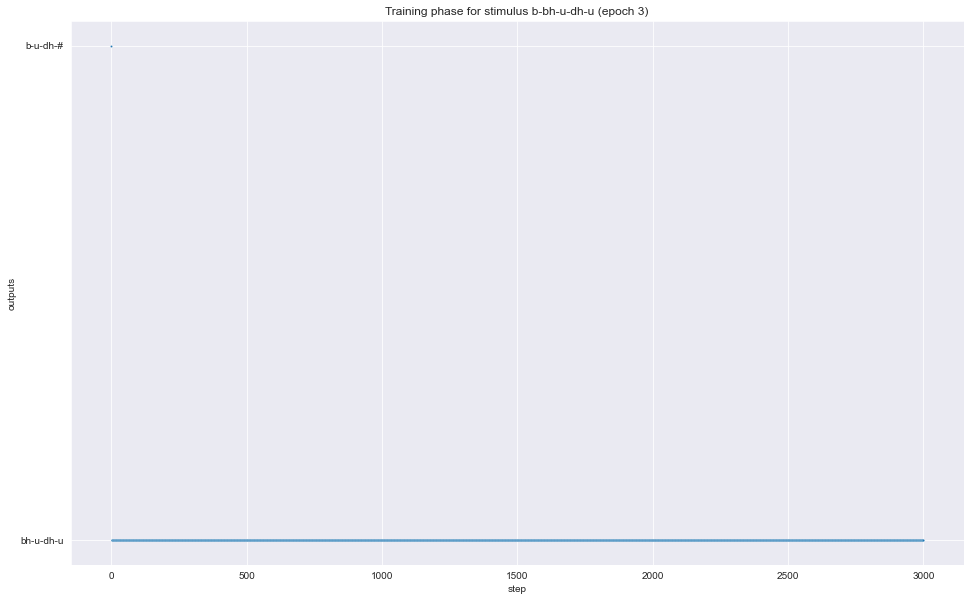

In [16]:
print("Given input: '(0.7 x bh + 0.8 x b)-u-dh-u'")
plt.figure(figsize=(16,10))
df = p.plot_epoch(0, 3)

Given input: 'b-u-dh'


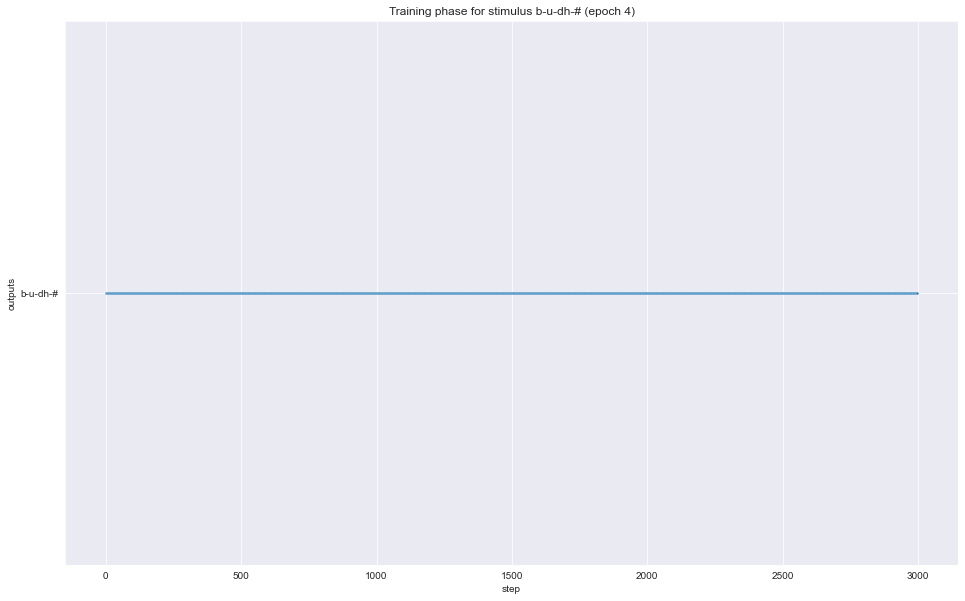

In [17]:
print("Given input: 'b-u-dh'")
plt.figure(figsize=(16,10))
df = p.plot_epoch(1, 4)

Given input: '(0.7 x bh + 0.8 x bh)-u-(.7 x d + .8 x dh)'


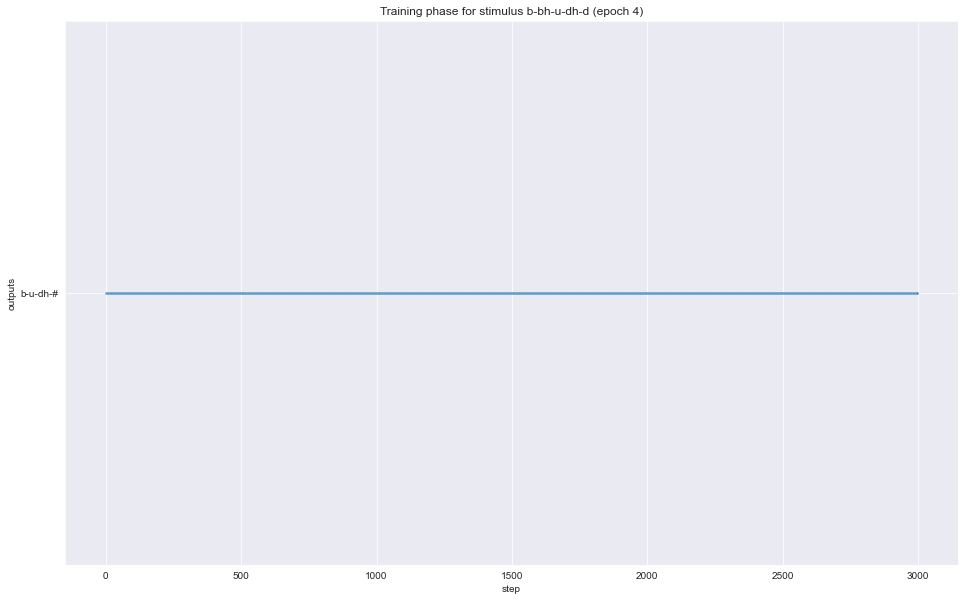

In [18]:
print("Given input: '(0.7 x bh + 0.8 x bh)-u-(.7 x d + .8 x dh)'")
plt.figure(figsize=(16,10))
df = p.plot_epoch(2, 4)

### Harmonies and Frequencies

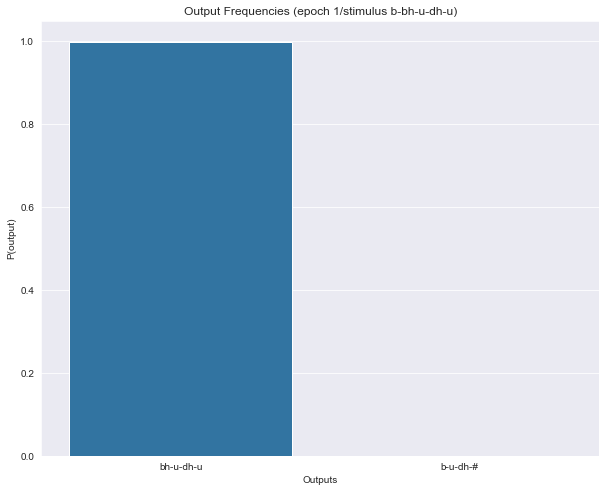

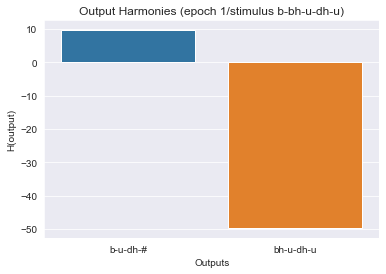

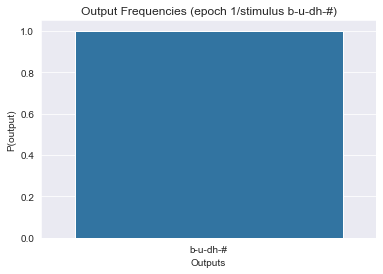

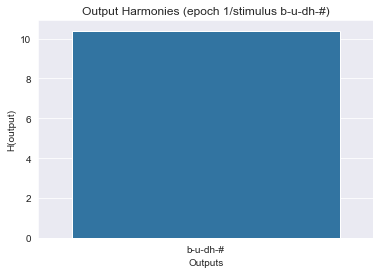

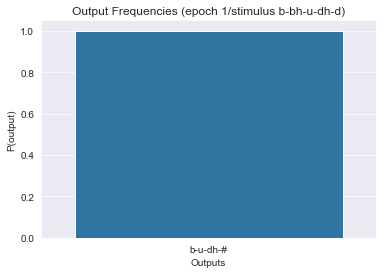

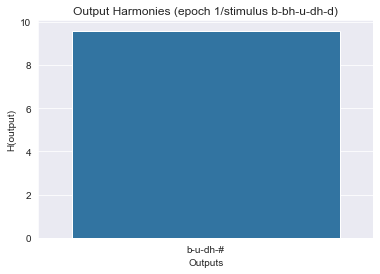

In [19]:
plt.figure(figsize=(10,8))
df = p.plot_final_states(save=True)

### Harmony vs. Activation

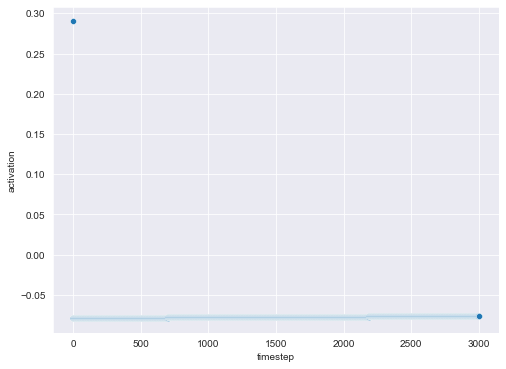

In [20]:
plt.figure(figsize=(8,6))
df = p.plot_act_stim(0,4, save=True)

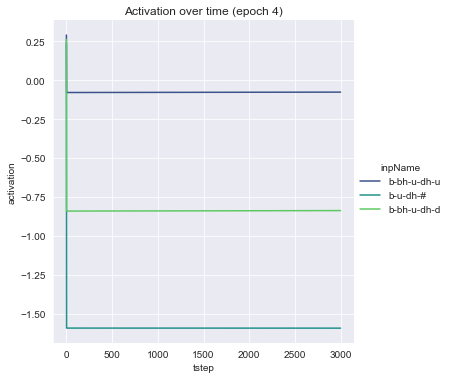

In [21]:
df = p.plot_input_tstep(4,what="activation")

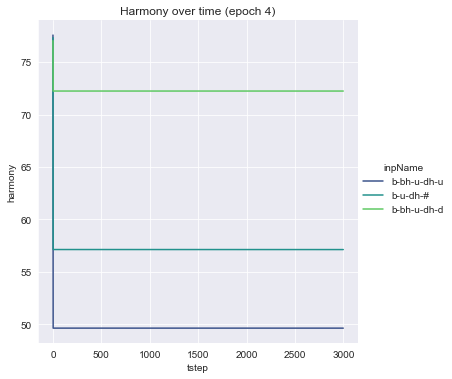

In [22]:
df = p.plot_input_tstep(4,what="harmony")
# Why???

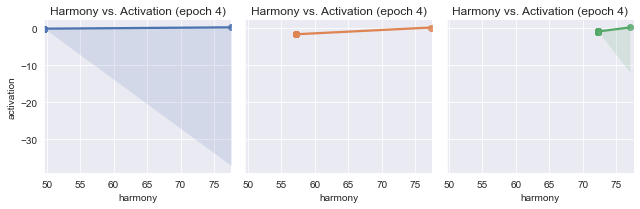

In [23]:
df = p.plot_input_tstep(4,what="regplot_facet")

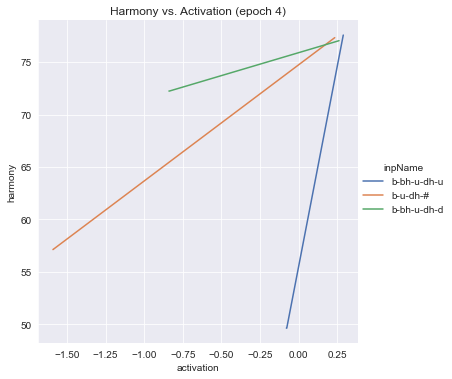

In [24]:
df = p.plot_input_tstep(4,what="regplot")

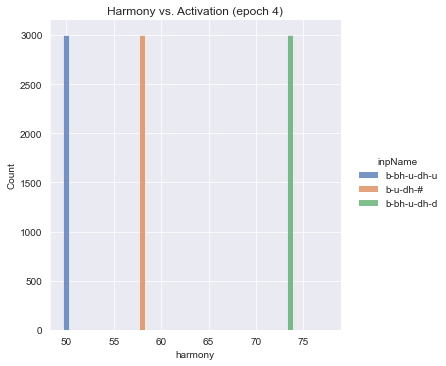

In [25]:
df = p.plot_input_tstep(4,what="harm_dist_inp")

## States update through time

In [26]:
data = p.data
c = data['C_trace']

In [27]:
# Input 0, epoch 4
mat = c[0, 4, i, :, :]
print(mat)
winner = ""
for i in range(mat.shape[1]):
    m = torch.argmax(mat[:,i])
    winner += fillers[m]
print(winner)

tensor([[0.8000, 0.4000, 0.4000, 0.4000],
        [0.7000, 0.4000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000, 1.0000],
        [0.4000, 0.4000, 0.4075, 0.4000],
        [0.4000, 0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 0.4000, 0.4422]])
bhudhu


step: 0 for input b-bh-u-dh-u 
Winner: budh#


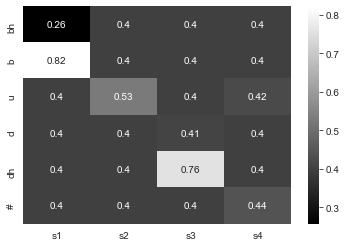

step: 2500 for input b-bh-u-dh-u 
Winner: bhudhu


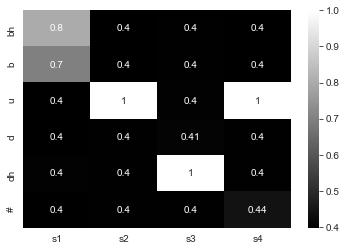

IndexError: index 5000 is out of bounds for dimension 2 with size 3000

In [28]:
for i in range(0, 10000,2500):
    mat = c[0, 3, i, :, :]
    df = pd.DataFrame(mat.numpy(), index=fillers, columns=roles)
    print(f"step: {i} for input {p.inputNames[0]} ")
    winner = ""
    for i in range(mat.shape[1]):
        m = torch.argmax(mat[:,i])
        winner += fillers[m]
    print(f"Winner: {winner}")
    sns.heatmap(df, annot=True, cmap="gray")
    plt.show()

In [ ]:
for i in range(0, 10000,2500):
    mat = c[0, 4, i, :, :]
    df = pd.DataFrame(mat.numpy(), index=fillers, columns=roles)
    print(f"step: {i} for input {p.inputNames[0]} ")
    winner = ""
    for i in range(mat.shape[1]):
        m = torch.argmax(mat[:,i])
        winner += fillers[m]
    print(f"Winner: {winner}")
    sns.heatmap(df, annot=True, cmap="gray")
    plt.show()